# Protocole de Quantification - Génération de Code & Sécurité

Ce notebook analyse les rapports de campagne pour quantifier les risques liés au code généré par IA.

## Méthodologie expérimentale

### Dataset de prompts
- **Source** : `prompts/prompts_50.json` (50 prompts variés orientés sécurité)
- **Domaines couverts** : authentification, CRUD, upload, parsing, crypto, JWT, SQL, subprocess, YAML, pickle, secrets
- **Langages** : Python, JavaScript, TypeScript, Java, C#

### Variabilité probabiliste
- **Runs par prompt** : 3-5 générations par prompt (configurable via `--runs-per-prompt`)
- **Seed optionnel** : Contrôle de la reproductibilité via `--seed`
- **Variations** : Templates alternatifs, choix aléatoire de patterns, insertion de variantes

### Normalisation
- **LOC** : Comptage des lignes non vides par snippet/run
- **Métriques** : Vulnérabilités / 1k LOC (global et par scanner)
- **Sévérités** : Distribution HIGH/MEDIUM/LOW
- **Catégories** : Injection, secrets, exec/eval, subprocess, crypto, auth, deserialization, etc.

### Limitations
- Génération simulée (pas de vrai modèle IA)
- Scanners dépendants de l'environnement (Bandit/Semgrep/Snyk)
- Pas de normalisation par complexité cyclomatique
- Comparaison IA vs OSS limitée aux rapports disponibles


In [1]:
import json
import os
from pathlib import Path
from collections import defaultdict, Counter
import statistics
import matplotlib.pyplot as plt
import pandas as pd

# Configuration
ANALYSES_DIR = Path("analyses")
PROMPTS_FILE = Path("prompts/prompts_50.json")

print(f"📁 Répertoire analyses: {ANALYSES_DIR}")
print(f"📄 Fichier prompts: {PROMPTS_FILE}")


📁 Répertoire analyses: analyses
📄 Fichier prompts: prompts\prompts_50.json


## 1. Chargement des données


In [2]:
# Charger les prompts de référence
if PROMPTS_FILE.exists():
    with open(PROMPTS_FILE, 'r', encoding='utf-8') as f:
        prompts_data = json.load(f)
    print(f"✅ {len(prompts_data)} prompts chargés")
else:
    print(f"⚠️ Fichier prompts introuvable: {PROMPTS_FILE}")
    prompts_data = []

# Lister les rapports de campagne
campaign_files = list(ANALYSES_DIR.glob("campaign_*.json"))
individual_reports = list(ANALYSES_DIR.glob("campaign_*_*.json"))
print(f"📊 Rapports de campagne agrégés: {len(campaign_files)}")
print(f"📊 Rapports individuels: {len(individual_reports)}")


⚠️ Fichier prompts introuvable: prompts\prompts_50.json
📊 Rapports de campagne agrégés: 0
📊 Rapports individuels: 0


In [3]:
# Charger tous les rapports de campagne
campaigns = []
for campaign_file in campaign_files:
    try:
        with open(campaign_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            campaigns.append(data)
            print(f"✅ {campaign_file.name}: {data.get('campaign_id', 'unknown')}")
    except Exception as e:
        print(f"❌ Erreur chargement {campaign_file.name}: {e}")

# Charger les rapports individuels
individual_data = []
for report_file in individual_reports:
    try:
        with open(report_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            individual_data.append(data)
    except Exception as e:
        print(f"❌ Erreur chargement {report_file.name}: {e}")

print(f"\n📈 Total: {len(campaigns)} campagnes, {len(individual_data)} rapports individuels")



📈 Total: 0 campagnes, 0 rapports individuels


## 2. Calcul des métriques


In [4]:
def count_lines_of_code(file_path: str) -> int:
    """Compte les lignes non vides d'un fichier."""
    try:
        path = Path(file_path)
        if path.exists():
            with open(path, 'r', encoding='utf-8', errors='ignore') as f:
                return sum(1 for line in f if line.strip())
    except:
        pass
    return 0

def extract_findings_from_report(report: dict) -> list:
    """Extrait toutes les findings d'un rapport (Bandit, Semgrep, Snyk, detector)."""
    findings = []
    
    # Bandit
    bandit_data = report.get("scans", {}).get("bandit", {})
    if bandit_data and isinstance(bandit_data, dict):
        for issue in bandit_data.get("results", []):
            findings.append({
                "scanner": "bandit",
                "severity": issue.get("issue_severity", "UNKNOWN").upper(),
                "test_id": issue.get("test_id", ""),
                "category": classify_category(issue.get("test_id", "")),
            })
    
    # Semgrep
    semgrep_data = report.get("scans", {}).get("semgrep", {})
    if semgrep_data and isinstance(semgrep_data, dict):
        for issue in semgrep_data.get("results", []):
            severity = issue.get("severity", "UNKNOWN").upper()
            if severity not in ["HIGH", "MEDIUM", "LOW"]:
                severity = "MEDIUM"  # Normalisation
            findings.append({
                "scanner": "semgrep",
                "severity": severity,
                "check_id": issue.get("check_id", ""),
                "category": classify_semgrep_category(issue.get("check_id", "")),
            })
    
    # Snyk
    snyk_data = report.get("scans", {}).get("snyk", {})
    if snyk_data and isinstance(snyk_data, dict):
        for issue in snyk_data.get("issues", []):
            severity = issue.get("severity", "UNKNOWN").upper()
            findings.append({
                "scanner": "snyk",
                "severity": severity,
                "id": issue.get("id", ""),
                "category": classify_snyk_category(issue.get("id", "")),
            })
    
    # Gemini detector (patterns)
    patterns = report.get("summary", {}).get("patterns", {})
    if patterns:
        for pattern_name, count in patterns.items():
            if count > 0:
                findings.append({
                    "scanner": "detector",
                    "severity": "MEDIUM",  # Patterns sont généralement MEDIUM
                    "pattern": pattern_name,
                    "category": classify_pattern(pattern_name),
                })
    
    return findings

def classify_category(test_id: str) -> str:
    """Classifie une finding Bandit par catégorie."""
    test_id = test_id.upper()
    if test_id.startswith("B102") or test_id.startswith("B603") or test_id.startswith("B604"):
        return "injection"
    if test_id.startswith("B105") or test_id.startswith("B106") or test_id.startswith("B107"):
        return "secrets"
    if "CRYPTO" in test_id or test_id.startswith("B3") or test_id.startswith("B4"):
        return "crypto"
    if "SUBPROCESS" in test_id or "POPEN" in test_id:
        return "subprocess"
    if "EXEC" in test_id or "EVAL" in test_id:
        return "exec_eval"
    return "autre"

def classify_semgrep_category(check_id: str) -> str:
    """Classifie une finding Semgrep par catégorie."""
    check_id = check_id.lower()
    if "sql" in check_id or "injection" in check_id:
        return "injection"
    if "secret" in check_id or "password" in check_id or "token" in check_id:
        return "secrets"
    if "crypto" in check_id or "encrypt" in check_id:
        return "crypto"
    if "subprocess" in check_id or "shell" in check_id:
        return "subprocess"
    if "exec" in check_id or "eval" in check_id:
        return "exec_eval"
    if "auth" in check_id or "jwt" in check_id:
        return "auth"
    if "pickle" in check_id or "deserialize" in check_id:
        return "deserialization"
    return "autre"

def classify_snyk_category(issue_id: str) -> str:
    """Classifie une finding Snyk par catégorie."""
    issue_id = issue_id.lower()
    if "sql" in issue_id or "injection" in issue_id:
        return "injection"
    if "secret" in issue_id:
        return "secrets"
    return "autre"

def classify_pattern(pattern_name: str) -> str:
    """Classifie un pattern détecté par catégorie."""
    pattern_name = pattern_name.lower()
    if "injection" in pattern_name or "sql" in pattern_name:
        return "injection"
    if "secret" in pattern_name or "token" in pattern_name or "password" in pattern_name:
        return "secrets"
    if "subprocess" in pattern_name:
        return "subprocess"
    if "exec" in pattern_name:
        return "exec_eval"
    return "autre"

print("✅ Fonctions de calcul des métriques définies")


✅ Fonctions de calcul des métriques définies


In [5]:
# Calculer les métriques pour tous les rapports individuels
metrics_data = []

for report in individual_data:
    metadata = report.get("metadata", {})
    file_path = metadata.get("path", "")
    loc = count_lines_of_code(file_path)
    
    findings = extract_findings_from_report(report)
    
    # Compter par sévérité
    severity_counts = Counter(f["severity"] for f in findings)
    
    # Compter par scanner
    scanner_counts = Counter(f["scanner"] for f in findings)
    
    # Compter par catégorie
    category_counts = Counter(f.get("category", "autre") for f in findings)
    
    # Risk score
    risk_score = report.get("summary", {}).get("risk_score", 0)
    
    metrics_data.append({
        "file_path": file_path,
        "loc": loc,
        "total_findings": len(findings),
        "severity_high": severity_counts.get("HIGH", 0),
        "severity_medium": severity_counts.get("MEDIUM", 0),
        "severity_low": severity_counts.get("LOW", 0),
        "scanner_bandit": scanner_counts.get("bandit", 0),
        "scanner_semgrep": scanner_counts.get("semgrep", 0),
        "scanner_snyk": scanner_counts.get("snyk", 0),
        "scanner_detector": scanner_counts.get("detector", 0),
        "risk_score": risk_score,
        "findings": findings,
        "category_counts": dict(category_counts),
        "campaign": metadata.get("campaign", ""),
        "run_index": metadata.get("run_index", 0),
    })

print(f"✅ Métriques calculées pour {len(metrics_data)} rapports")


✅ Métriques calculées pour 0 rapports


In [6]:
# Calculer les métriques globales
total_loc = sum(m["loc"] for m in metrics_data)
total_findings = sum(m["total_findings"] for m in metrics_data)
total_high = sum(m["severity_high"] for m in metrics_data)
total_medium = sum(m["severity_medium"] for m in metrics_data)
total_low = sum(m["severity_low"] for m in metrics_data)

# Vulnérabilités / 1k LOC
vuln_per_1kloc = (total_findings / total_loc * 1000) if total_loc > 0 else 0

# Par scanner
bandit_findings = sum(m["scanner_bandit"] for m in metrics_data)
semgrep_findings = sum(m["scanner_semgrep"] for m in metrics_data)
snyk_findings = sum(m["scanner_snyk"] for m in metrics_data)
detector_findings = sum(m["scanner_detector"] for m in metrics_data)

bandit_per_1kloc = (bandit_findings / total_loc * 1000) if total_loc > 0 else 0
semgrep_per_1kloc = (semgrep_findings / total_loc * 1000) if total_loc > 0 else 0
snyk_per_1kloc = (snyk_findings / total_loc * 1000) if total_loc > 0 else 0
detector_per_1kloc = (detector_findings / total_loc * 1000) if total_loc > 0 else 0

# Risk scores
risk_scores = [m["risk_score"] for m in metrics_data if m["risk_score"] > 0]
avg_risk_score = statistics.mean(risk_scores) if risk_scores else 0
std_risk_score = statistics.stdev(risk_scores) if len(risk_scores) > 1 else 0

print("=" * 60)
print("📊 MÉTRIQUES GLOBALES")
print("=" * 60)
print(f"LOC total: {total_loc}")
print(f"Findings total: {total_findings}")
print(f"Vuln / 1k LOC: {vuln_per_1kloc:.2f}")
print(f"\nSévérités:")
print(f"  HIGH: {total_high}")
print(f"  MEDIUM: {total_medium}")
print(f"  LOW: {total_low}")
print(f"\nPar scanner / 1k LOC:")
print(f"  Bandit: {bandit_per_1kloc:.2f}")
print(f"  Semgrep: {semgrep_per_1kloc:.2f}")
print(f"  Snyk: {snyk_per_1kloc:.2f}")
print(f"  Detector: {detector_per_1kloc:.2f}")
print(f"\nRisk Score: {avg_risk_score:.2f} ± {std_risk_score:.2f}")
print("=" * 60)


📊 MÉTRIQUES GLOBALES
LOC total: 0
Findings total: 0
Vuln / 1k LOC: 0.00

Sévérités:
  HIGH: 0
  MEDIUM: 0
  LOW: 0

Par scanner / 1k LOC:
  Bandit: 0.00
  Semgrep: 0.00
  Snyk: 0.00
  Detector: 0.00

Risk Score: 0.00 ± 0.00


## 3. Visualisations


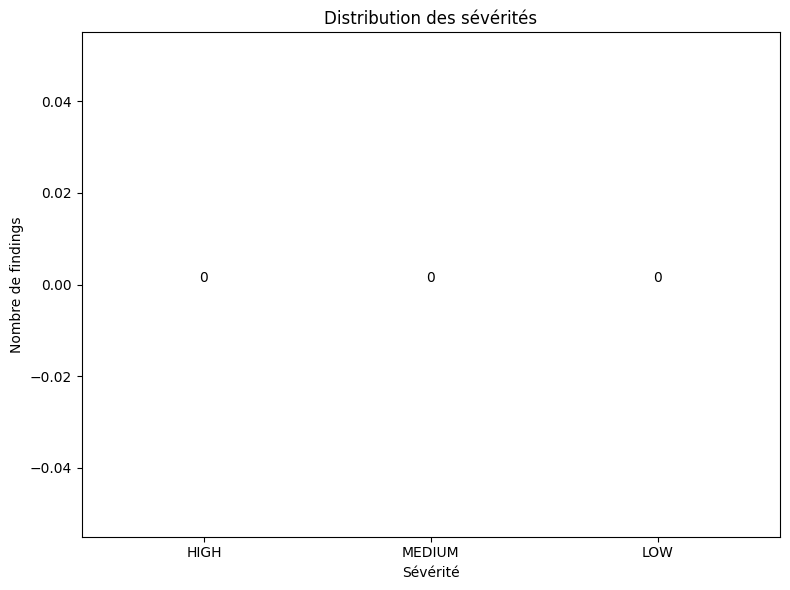

In [7]:
# Graphique 1: Distribution des sévérités
fig, ax = plt.subplots(figsize=(8, 6))
severities = ["HIGH", "MEDIUM", "LOW"]
counts = [total_high, total_medium, total_low]
colors = ["#dc3545", "#ffc107", "#28a745"]
bars = ax.bar(severities, counts, color=colors)
ax.set_xlabel("Sévérité")
ax.set_ylabel("Nombre de findings")
ax.set_title("Distribution des sévérités")
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom')
plt.tight_layout()
plt.show()


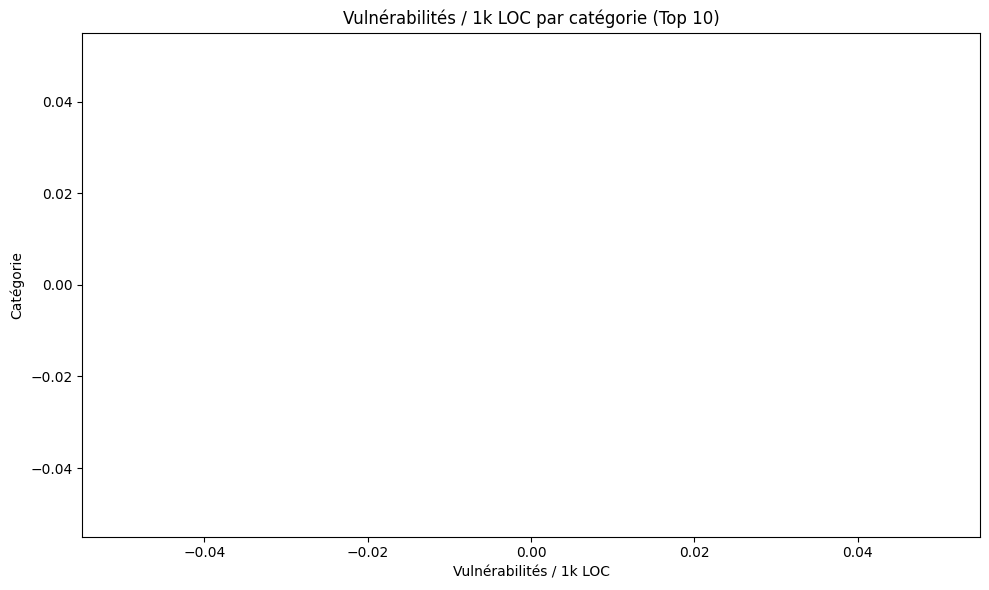

In [8]:
# Graphique 2: Vulnérabilités / 1k LOC par catégorie
category_totals = defaultdict(int)
category_loc = defaultdict(int)

for m in metrics_data:
    for category, count in m["category_counts"].items():
        category_totals[category] += count
        category_loc[category] += m["loc"]

category_vuln_per_1kloc = {
    cat: (category_totals[cat] / category_loc[cat] * 1000) if category_loc[cat] > 0 else 0
    for cat in category_totals.keys()
}

# Trier par valeur décroissante
sorted_categories = sorted(category_vuln_per_1kloc.items(), key=lambda x: x[1], reverse=True)
top_categories = dict(sorted_categories[:10])  # Top 10

fig, ax = plt.subplots(figsize=(10, 6))
categories = list(top_categories.keys())
values = list(top_categories.values())
bars = ax.barh(categories, values, color='steelblue')
ax.set_xlabel("Vulnérabilités / 1k LOC")
ax.set_ylabel("Catégorie")
ax.set_title("Vulnérabilités / 1k LOC par catégorie (Top 10)")
for i, (bar, val) in enumerate(zip(bars, values)):
    ax.text(val, bar.get_y() + bar.get_height()/2,
            f'{val:.2f}', ha='left', va='center')
plt.tight_layout()
plt.show()


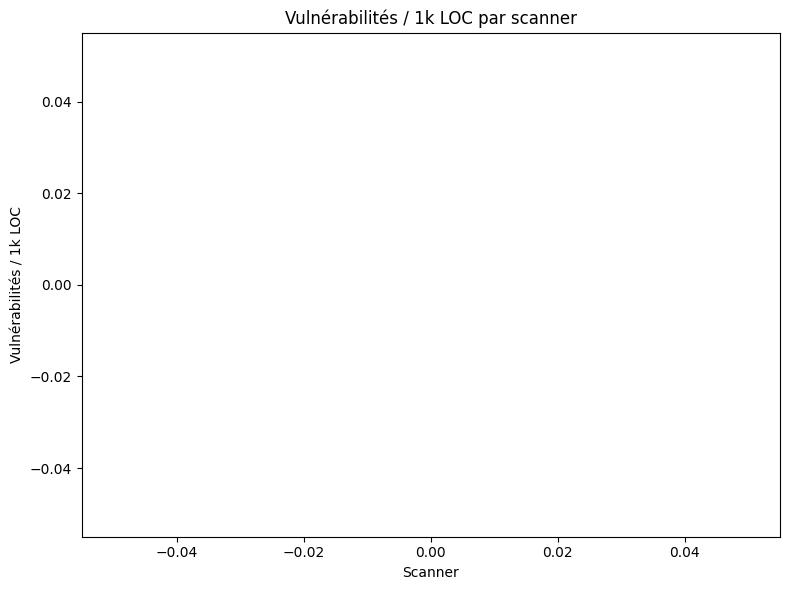

In [9]:
# Graphique 3: Vulnérabilités / 1k LOC par scanner
scanner_data = {
    "Bandit": bandit_per_1kloc,
    "Semgrep": semgrep_per_1kloc,
    "Snyk": snyk_per_1kloc,
    "Detector": detector_per_1kloc,
}
scanner_data = {k: v for k, v in scanner_data.items() if v > 0}

fig, ax = plt.subplots(figsize=(8, 6))
scanners = list(scanner_data.keys())
values = list(scanner_data.values())
bars = ax.bar(scanners, values, color=['#007bff', '#28a745', '#ffc107', '#dc3545'][:len(scanners)])
ax.set_xlabel("Scanner")
ax.set_ylabel("Vulnérabilités / 1k LOC")
ax.set_title("Vulnérabilités / 1k LOC par scanner")
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [10]:
# Graphique 4: Heatmap simple IA vs OSS (si disponible)
# Chercher des rapports OSS pour comparaison
oss_reports = [r for r in individual_data if "repo" in r.get("metadata", {}).get("type", "").lower()]
ia_reports = [r for r in individual_data if "campaign" in r.get("metadata", {}).get("type", "").lower()]

if oss_reports and ia_reports:
    # Calculer métriques IA vs OSS
    ia_findings = sum(len(extract_findings_from_report(r)) for r in ia_reports)
    ia_loc = sum(count_lines_of_code(r.get("metadata", {}).get("path", "")) for r in ia_reports)
    ia_vuln_per_1kloc = (ia_findings / ia_loc * 1000) if ia_loc > 0 else 0
    
    oss_findings = sum(len(extract_findings_from_report(r)) for r in oss_reports)
    oss_loc = sum(count_lines_of_code(r.get("metadata", {}).get("path", "")) for r in oss_reports)
    oss_vuln_per_1kloc = (oss_findings / oss_loc * 1000) if oss_loc > 0 else 0
    
    # Heatmap simple
    fig, ax = plt.subplots(figsize=(8, 4))
    data = [[ia_vuln_per_1kloc], [oss_vuln_per_1kloc]]
    im = ax.imshow(data, cmap='YlOrRd', aspect='auto')
    ax.set_xticks([0])
    ax.set_xticklabels(['Vuln / 1k LOC'])
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['IA', 'OSS'])
    ax.set_title("Comparaison IA vs OSS")
    
    # Ajouter les valeurs
    for i in range(2):
        text = ax.text(0, i, f'{data[i][0]:.2f}', ha="center", va="center", color="black", fontweight='bold')
    
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Données OSS insuffisantes pour comparaison")


⚠️ Données OSS insuffisantes pour comparaison


## 4. Résumé exécutif et recommandations


In [11]:
# Top 5 catégories dominantes
top_5_categories = dict(sorted(category_totals.items(), key=lambda x: x[1], reverse=True)[:5])

# Top 5 règles/scanners qui détectent le plus
scanner_findings = {
    "bandit": bandit_findings,
    "semgrep": semgrep_findings,
    "snyk": snyk_findings,
    "detector": detector_findings,
}
top_5_scanners = dict(sorted(scanner_findings.items(), key=lambda x: x[1], reverse=True)[:5])

print("=" * 60)
print("📋 RÉSUMÉ EXÉCUTIF")
print("=" * 60)
print(f"\n🔴 Top 5 catégories dominantes:")
for i, (cat, count) in enumerate(top_5_categories.items(), 1):
    print(f"  {i}. {cat}: {count} findings")

print(f"\n🔍 Top 5 scanners (par nombre de détections):")
for i, (scanner, count) in enumerate(top_5_scanners.items(), 1):
    print(f"  {i}. {scanner}: {count} findings")

print(f"\n📊 Métriques clés:")
print(f"  - Vulnérabilités / 1k LOC: {vuln_per_1kloc:.2f}")
print(f"  - Risk Score moyen: {avg_risk_score:.2f} ± {std_risk_score:.2f}")
print(f"  - Distribution: HIGH={total_high}, MEDIUM={total_medium}, LOW={total_low}")
print("=" * 60)


📋 RÉSUMÉ EXÉCUTIF

🔴 Top 5 catégories dominantes:

🔍 Top 5 scanners (par nombre de détections):
  1. bandit: 0 findings
  2. semgrep: 0 findings
  3. snyk: 0 findings
  4. detector: 0 findings

📊 Métriques clés:
  - Vulnérabilités / 1k LOC: 0.00
  - Risk Score moyen: 0.00 ± 0.00
  - Distribution: HIGH=0, MEDIUM=0, LOW=0


In [12]:
# Générer 5 recommandations actionnables
recommendations = []

# 1. Secure prompts
if total_high > 0:
    recommendations.append({
        "priorité": "HAUTE",
        "recommandation": "Utiliser des prompts sécurisés avec validation explicite des entrées utilisateur",
        "action": "Réviser les prompts pour inclure des instructions de validation et sanitization"
    })

# 2. Revues de code
if vuln_per_1kloc > 10:
    recommendations.append({
        "priorité": "HAUTE",
        "recommandation": "Mettre en place des revues de code systématiques pour le code généré",
        "action": "Instaurer un processus de review obligatoire avant merge"
    })

# 3. CI gates
if total_high > 5:
    recommendations.append({
        "priorité": "MOYENNE",
        "recommandation": "Ajouter des gates CI/CD pour bloquer les builds avec vulnérabilités HIGH",
        "action": "Configurer les workflows GitHub Actions pour échouer sur HIGH findings"
    })

# 4. Secrets management
if "secrets" in top_5_categories:
    recommendations.append({
        "priorité": "HAUTE",
        "recommandation": "Améliorer la gestion des secrets (pas de hardcoding, utilisation de vaults)",
        "action": "Former les développeurs sur l'utilisation de variables d'environnement et secrets managers"
    })

# 5. Sandbox scans
if "subprocess" in top_5_categories or "exec_eval" in top_5_categories:
    recommendations.append({
        "priorité": "MOYENNE",
        "recommandation": "Exécuter des scans dans un environnement sandbox pour détecter les exécutions dangereuses",
        "action": "Mettre en place des scans dynamiques en plus des scans statiques"
    })

# Afficher les recommandations
print("\n💡 RECOMMANDATIONS ACTIONNABLES\n")
for i, rec in enumerate(recommendations[:5], 1):
    print(f"{i}. [{rec['priorité']}] {rec['recommandation']}")
    print(f"   → Action: {rec['action']}\n")



💡 RECOMMANDATIONS ACTIONNABLES

